In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
from utils import show_prompt
from deep_research_with_langgraph.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

In [6]:
%%writefile ../src/deep_research_with_langgraph/state_multi_agent_supervisor.py
"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from pydantic import BaseModel, Field
from typing_extensions import Annotated, Sequence, TypedDict
from langchain_core.tools import  tool
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Writing ../src/deep_research_with_langgraph/state_multi_agent_supervisor.py


In [12]:
%%writefile ../src/deep_research_with_langgraph/multi_agent_supervisor.py
"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio
from langchain.chat_models import init_chat_model
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage, filter_messages
from langgraph.graph import END, START, StateGraph
from deep_research_with_langgraph.state_multi_agent_supervisor import ConductResearch, ResearchComplete, SupervisorState
from deep_research_with_langgraph.utils import think_tool, get_today_str
from deep_research_with_langgraph.prompts import lead_researcher_prompt
from deep_research_with_langgraph.research_agent import researcher_agent
from langgraph.types import Command
from typing_extensions import Literal

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it

# ===== CONFIGURATION =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model("gemini-2.5-flash", model_provider="google_genai", timeout=30, temperature=0)
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]

    # Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False

    # Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )

    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END

    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )
            
            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END

    # Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()


Writing ../src/deep_research_with_langgraph/multi_agent_supervisor.py


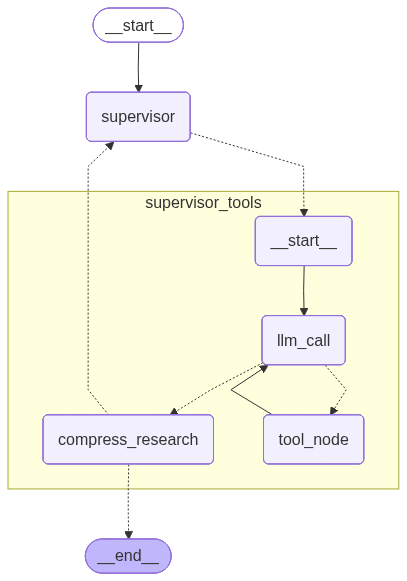

In [13]:
from IPython.display import Image, display
from deep_research_with_langgraph.multi_agent_supervisor import supervisor_agent
# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))


## Evals

In [14]:
# Example messages with think_tool calls and tool messages for evaluation
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [15]:
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

In [16]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-28f16b07' at:
https://smith.langchain.com/o/469b91a8-b891-4cd4-b99e-a7ed78ed0542/datasets/2b956aac-2f4b-4ebb-b159-a2f279a2cf1a/compare?selectedSessions=89d4710e-e114-432e-9bd5-30d15c4d27eb




2it [00:04,  2.21s/it]


<AsyncExperimentResults Supervisor Parallelism-28f16b07>